# TOC

__Chapter 4 - Convolutional neural networks__

1. [Import](#Import)
1. [Introduction to CNNs](#Introduction-to-CNNs)
1. [MNIST - Take 2](#MNIST)
    1. [Convolution](#Convolution)
    1. [Pooling](#Pooling)
    1. [Dropout](#Dropout)
    1. [Model](#Model)
1. [CIFAR10](#CIFAR10)
    1. [Load data](#Load-data)
    1. [Simple model](#Simple-model)
    1. [Better model](#Better-model)
    1. [Alternative approach](#Alternative-approach)

# Import

<a id = 'Import'></a>

In [1]:
# standard libary and settings
import os
import sys
import importlib
import itertools
import warnings

warnings.simplefilter("ignore")
modulePath = os.path.abspath(os.path.join("../../CustomModules"))
sys.path.append(modulePath) if modulePath not in sys.path else None
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.options.display.float_format = "{:,.6f}".format

import tensorflow as tf

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

# custom extensions and settings
sys.path.append("/home/mlmachine") if "/home/mlmachine" not in sys.path else None
sys.path.append("/home/prettierplot") if "/home/prettierplot" not in sys.path else None

import mlmachine as mlm
from prettierplot.plotter import PrettierPlot
import prettierplot.style as style

# magic functions
%matplotlib inline

# Introduction to CNNs

Contrasting with fully connected neural networks, units in CNNs are connected to a (typically  small) number of nearby units in the previous layer. Further, all units are connected to the previous layer in the same way, with the exact same weights and structure. This facilitates an operation know as convolution, which can be thought as the application of a 'window' of weights. This windows slides along the surface of the image. This helps to address the fact that an object can appear in many different locations in a picture, and the perspective of an object will certainly differ from image to image. The is known as 'invariance'. The convolutional approach to learning weights addressse this by performing the same exact computation on different parts of the image.



<a id = 'Introduction-to-CNNs'></a>

# MNIST - Take 2

Modeling using the MNIST dataset, this time with a small CNN.

<a id = 'MNIST'></a>

## Convolution

The convolutation operation is the fundamental means by which layers are connected in CNNs. TensorFlow has a build in operation conv2d()

```python
tf.nn.conv2d(x, W, strides = [1,1,1,1], padding = 'SAME'
```

Here, 'x' is the data - which is either the input image or a downstream feature map obtained further along in the network following previous convolutional layers. A feature map is the output of each layer. The output of each layer can also be thought of as a 'processed' image, the result of applying a filter and perhaps some other operations. 

The filter is parameterized by W, which is comprised of the learned weights of our network. This convolutional filter is the small 'sliding window' that slides across the face of the image.

The output of this operation will depend on the shape of X and W. In this case, the output is four-dimensional. The image data X is of shape: [None, 28, 28, 1], meaning we have an unknown number of images, each has 28 x 28 pixels, with one color channel (grayscale). The weights W is of shape: [5, 5, 1, 32], where the initial 5 x 5 x 1 represents the size of the 'window' in the image to be convolved, which in this is a 5 by 5 region. The 32 represents the number of feature maps. In other words, we have multiple sets of weights for the convolutional layer. The idea of a convolutional layer is to compute the same feature along the image - we would like to compute many such features and thus use multiple sets of convolutional filters.

The 'strides' argument controls the spatial movement of the filter window W across the image (or feature map) x. The value [1,1,1,1] means that the filter is applied to the input in 1-ixel intervals, which can be thought of as a full convolution. Increasing the stride will result in a smaller feature map.

Lastly, the padding argument is set to 'SAME', which means that the border of x are padded such that the size of the result of the operation is the same as the size of x. This allows the window to give similar attention to the pixels on the border of the image and the pixels in the middle of the image.

<a id = 'Convolution'></a>

## Pooling

Pooling means reducing the size of the data with some local aggregation function, typically within each feature map. The technical aspect of this operation is that pooling reduces the size of the data processed downstream. This drastically reduces the number of parameters in the model, particularly if we use fully connected layers after the convolutional layer. The theoretical aspect of pooling is that we would like our features to not care too much about small changes in position in an image. This allows the process to over spatial variability between images.

```python
tf.nn.max_pool(x, ksize = [1,2,2,1], stides = [1,2,2,1], padding = 'SAME')
```

The ksize argument controls the size of the pooling and strides controls how much the pooling grid slides across x, just as it does in the convolution layer. Setting strides to a 2x2 grid means the output of the pooling will be exactly one-half of the height and width of the original - one-quarter of the original size overall.

<a id = 'Pooling'></a>

## Dropout

Dropout is a regularization trick used to force the network to distribute the learned representation across all nuerons. Dropout 'turns off a random preset fraction of units in a layer by setting their values to zero during training. These dropped neurons are random, and different for each computation, which forces the network to learn a representation that will work despite the dropout. This process can be thought of training an 'ensemble of multiple network that have a different understanding of the training data, which tends to increase generalization. Dropout is not used in the test phase.

```python
tf.nn.dropout(layer, keep_prob = 0.1)
```


<a id = 'Dropout'></a>

## Model

<a id = 'Model'></a>

In [2]:
# helper functions
def weight_variable(shape):
    """
    Info:
        Description:
            Specifies weights for either a fully connected layer or convolutional layer. 
            Randomized initially using a truncated normal distribution with a SD of 0.1. 
            This is a pretty typical randomization method.
    """
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    """
    Info:
        Description:
            Defines bias elements in either a fully connected layer or convolutional layer.
            Initialized with the constant value of 0.1
    """
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, W):
    """
    Info:
        Description:
            Specifies the convolution that will typically be used.
            This represents a full convolution (no skipping) with padding 
            that creates an output that is the same size as the input.
    """
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding="SAME")


def max_pool_2x2(x):
    """
    Info:
        Description:
            Sets the max pool to half the size across both the height and width.
            In total, the output is one quarter of the size of the input feature map.
    """
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")


def conv_layer(input, shape):
    """
    Info:
        Description:
            The convolutional layer, linear convolution as defined in conv2d, with a
            bias followed by the ReLU activation function.
    """
    W = weight_variable(shape)
    b = bias_variable([shape[3]])
    return tf.nn.relu(conv2d(input, W) + b)


def full_layer(input, size):
    """
    Info:
        Description:
            A standard full layer with a bias. To be used for the final output.
    """
    in_size = int(input.get_shape()[1])
    W = weight_variable([in_size, size])
    b = bias_variable([size])
    return tf.matmul(input, W) + b

> Remarks - Random initialization, as opposed to constant initialization, helps break the symmetry between learned features which allows the modle to learn a diverse and rich representation. Using a bound (truncated) distribution helps control the magnitude of the gradients, allowing the network to ocnverge more efficiently.

In [3]:
# setup model
# 28 x 28 pixel input
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

x_image = tf.reshape(x, [-1, 28, 28, 1])

# 5 x 5 x 32 feature map. Creates 28 x 28 x 32 feature map followed by 2x2 max pooling
conv1 = conv_layer(x_image, shape=[5, 5, 1, 32])
conv1_pool = max_pool_2x2(conv1)

# 5 x 5 x 32 x 64 (5 by 5 tiles, 32 deep, 64 sets)
# creates 14 x 14 x 64 feature map followed by 2x2 max pooling
conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)

# 7 x 7 x 64 fully connected layer
conv2_flat = tf.reshape(conv2_pool, [-1, 7 * 7 * 64])
full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))

# dropouts
keep_prob = tf.placeholder(tf.float32)
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, 10)

W0720 17:12:22.376879 140160958227456 deprecation.py:506] From <ipython-input-3-7556e89479d5>:23: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


> Remarks - First placeholders are defined for the input images and correct labels. Next the input image is reshaped into the @D image format of size 28 x 28 x 1. In the basic logistic regression implemented earlier, since all pixels were treated independently. With a CNN, however, its power comes from the utilization of spatial meaning pixels and nearby pixels.

> Next, two consecutive convolutional layers and pools, each with 5 x 5 convolutions and 32 feature maps. These are followed by a single fully connected layer with 1,024 units. Prior to the image arriving at this fully connected layer, we flatten the image back to a single vector form since the fully connected layer derives no benefit from the spatial relationships of between pixels.

> After the second convolution/pooling layer, the size of the image is 7 x 7 x 64. the original 28 x 28 pixel image is reduced to 14 x 14 by the first pooling operation, and then to 7 x 7 by the second pooling operation. The '64' in 7 x 7 x 64 is the number of feature maps creates in the second convolutional layer.

> One interesting thing to note is that the number of parameters between the 7 x 7 x 64 layer and the fully connected 1 x 1 x 1,024 layer is 3.2 million. Without max pooling, which would give us a 28 x 28 x 64 feature map, would yield 51 million parameters.

> Lastly, the output is a fully connected layer with 10 units, one unit for each handwritten digit.

In [4]:
# execute model
from tensorflow.examples.tutorials.mnist import input_data

DATA_DIR = "/main/tmp/data"
STEPS = 5000
mnist = input_data.read_data_sets(DATA_DIR, one_hot=True)

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_)
)
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(STEPS):
        batch = mnist.train.next_batch(50)

        if i % 250 == 0:
            train_accuracy = sess.run(
                accuracy, feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0}
            )
            print("step {}, training accuracy {}".format(i, train_accuracy))

        sess.run(train_step, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    X = mnist.test.images.reshape(10, 1000, 784)
    Y = mnist.test.labels.reshape(10, 1000, 10)
    test_accuracy = np.mean(
        [
            sess.run(accuracy, feed_dict={x: X[i], y_: Y[i], keep_prob: 1.0})
            for i in range(10)
        ]
    )

print("test accuracy: {}".format(test_accuracy))

W0720 17:12:25.854724 140160958227456 deprecation.py:323] From <ipython-input-4-0891cc45d3f9>:6: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0720 17:12:25.862690 140160958227456 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0720 17:12:25.864151 140160958227456 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instruction

Extracting /main/tmp/data/train-images-idx3-ubyte.gz


W0720 17:12:26.376070 140160958227456 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0720 17:12:26.381693 140160958227456 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.
W0720 17:12:26.494853 140160958227456 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be remove

Extracting /main/tmp/data/train-labels-idx1-ubyte.gz
Extracting /main/tmp/data/t10k-images-idx3-ubyte.gz
Extracting /main/tmp/data/t10k-labels-idx1-ubyte.gz


W0720 17:12:26.783505 140160958227456 deprecation.py:323] From <ipython-input-4-0891cc45d3f9>:9: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



step 0, training accuracy 0.10000000149011612
step 250, training accuracy 0.8999999761581421
step 500, training accuracy 0.9599999785423279
step 750, training accuracy 0.8600000143051147
step 1000, training accuracy 0.9399999976158142
step 1250, training accuracy 1.0
step 1500, training accuracy 0.9200000166893005
step 1750, training accuracy 0.9399999976158142
step 2000, training accuracy 0.9800000190734863
step 2250, training accuracy 1.0
step 2500, training accuracy 0.9800000190734863
step 2750, training accuracy 0.9800000190734863
step 3000, training accuracy 0.9800000190734863
step 3250, training accuracy 0.9599999785423279
step 3500, training accuracy 0.9800000190734863
step 3750, training accuracy 0.9800000190734863
step 4000, training accuracy 1.0
step 4250, training accuracy 0.9800000190734863
step 4500, training accuracy 0.9800000190734863
step 4750, training accuracy 1.0
test accuracy: 0.9855999946594238


# CIFAR10

The CIFAR10 dataset contains a set of 60,000 color images of size 32 x 32 pixels, each belonging to one of ten categories:

- airplane
- automobile
- bird
- cat 
- deer
- dog
- frog
- horse
- ship
- truck


<a id = 'CIFAR10'></a>

## Load data

Download the data from [here](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

Unzip the folder from the command line in "main/tmp": 

    tar xvzr cifar-10-python.tar.gz

<a id = 'Load-data'></a>

In [5]:
import _pickle as cPickle

# create custom data loader
path = "../../data/cifar-10-batches-py"

class CifarLoader:
    def __init__(self, source_files):
        self._source = source_files
        self._i = 0
        self.images = None
        self.labels = None

    def load(self):
        data = [unpickle(f) for f in self._source]
        images = np.vstack([d["data"] for d in data])
        n = len(images)
        self.images = (
            images.reshape(n, 3, 32, 32).transpose(0, 2, 3, 1).astype(float) / 255
        )
        self.labels = one_hot(np.hstack([d["labels"] for d in data]), 10)
        return self

    def next_batch(self, batch_size):
        x, y = (
            self.images[self._i : self._i + batch_size],
            self.labels[self._i : self._i + batch_size],
        )
        self._i = (self._i + batch_size) % len(self.images)
        return x, y


# unpickle function
def unpickle(file):
    """
    Info:
        Description:
            Returns dictionary with fields 'data' and 'labels'.
    """
    with open(os.path.join(path, file), "rb") as fo:
        dict = cPickle.load(fo, encoding="latin1")
    return dict


# custom one hot encoder
def one_hot(vec, vals=10):
    """
    Info:
        Description:
            Recodes the labels from integer in rnage 0 to 9 into
            vectors of length 10, contains 0's except for a 1 at the
            position of the label.
    """
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [6]:
# custom dataset handler
class CifarDataManager:
    def __init__(self):
        self.train = CifarLoader(
            ["data_batch_{}".format(i) for i in range(1, 6)]
        ).load()
        self.test = CifarLoader(["test_batch"]).load()

Number of train images: 50000
Number of train images: 50000
Number of test images: 10000
Number of test images: 10000


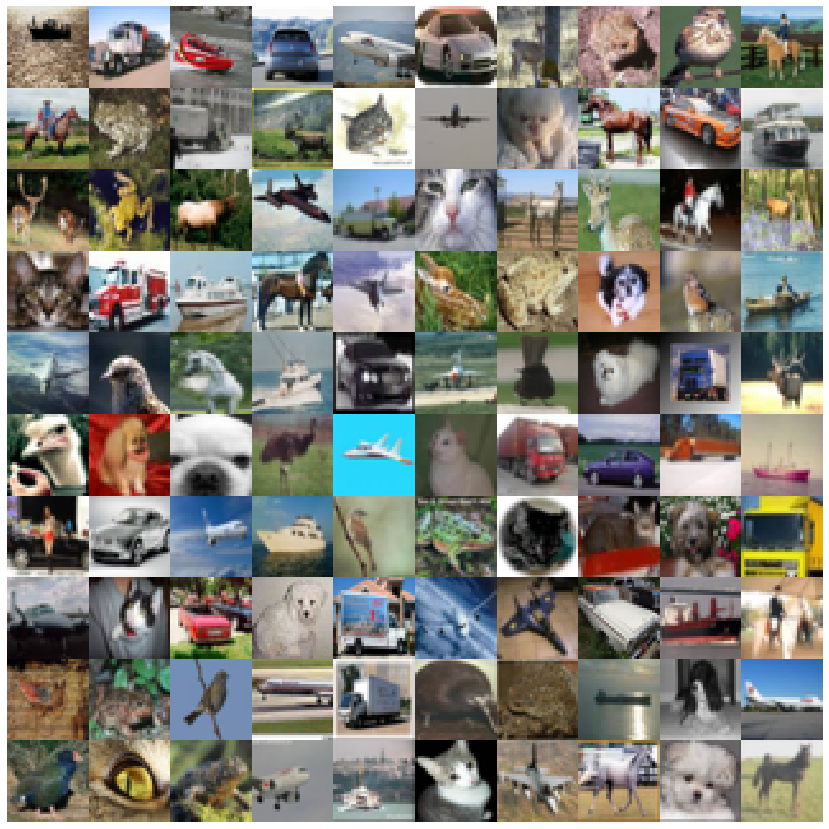

In [7]:
# display sample images
def display_cifar(images, size):
    n = len(images)
    plt.figure(figsize=(15, 15))
    plt.gca().set_axis_off()
    im = np.vstack(
        [
            np.hstack([images[np.random.choice(n)] for i in range(size)])
            for i in range(size)
        ]
    )
    plt.imshow(im)
    plt.show()


d = CifarDataManager()
print("Number of train images: {}".format(len(d.train.images)))
print("Number of train images: {}".format(len(d.train.labels)))
print("Number of test images: {}".format(len(d.test.images)))
print("Number of test images: {}".format(len(d.test.labels)))

images = d.train.images
display_cifar(images, 10)

## Simple model

<a id = 'Simple-model'></a>

In [8]:
#  simple CNN
STEPS = 3000
BATCH_SIZE = 100

cifar = CifarDataManager()

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

conv1 = conv_layer(x, shape=[5, 5, 3, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)
conv2_flat = tf.reshape(conv2_pool, [-1, 8 * 8 * 64])

full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, 10)

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_)
)

train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


def test(sess):
    X = cifar.test.images.reshape(10, 1000, 32, 32, 3)
    Y = cifar.test.labels.reshape(10, 1000, 10)
    acc = np.mean(
        [
            sess.run(accuracy, feed_dict={x: X[i], y_: Y[i], keep_prob: 1.0})
            for i in range(10)
        ]
    )
    print("Accuracy: {:.4}".format(acc * 100))


# run session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(STEPS):
        batch = cifar.train.next_batch(BATCH_SIZE)

        if i % 250 == 0:
            train_accuracy = sess.run(
                accuracy, feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0}
            )
            print("step {}, training accuracy {}".format(i, train_accuracy))
        sess.run(train_step, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
    test(sess)

step 0, training accuracy 0.10000000149011612
step 250, training accuracy 0.550000011920929
step 500, training accuracy 0.47999998927116394
step 750, training accuracy 0.5799999833106995
step 1000, training accuracy 0.6399999856948853
step 1250, training accuracy 0.6000000238418579
step 1500, training accuracy 0.7400000095367432
step 1750, training accuracy 0.6800000071525574
step 2000, training accuracy 0.7699999809265137
step 2250, training accuracy 0.8500000238418579
step 2500, training accuracy 0.7799999713897705
step 2750, training accuracy 0.8299999833106995
Accuracy: 67.12


> Remarks - A key difference between this model and the MNIST model:
```python
x = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
```
The '3' in the final position of the list defining the placeholder's shape corresponds to the 3 color channels available in the color CIFAR image.


## Better model

We can also add a third convolution layer with 128 feature maps and dropout. We also reduce the number of units in the fully connected layer from 1,024 to 512

This model will take longer to train but will increase the accuracy to around 75%.

<a id = 'Better-model'></a>

In [9]:
# better CNN model that introduces additional layer and dropout
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

conv1 = conv_layer(x, shape=[5, 5, 3, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)

conv3 = conv_layer(conv2_pool, shape=[5, 5, 64, 128])
conv3_pool = max_pool_2x2(conv3)
conv3_flat = tf.reshape(conv3_pool, [-1, 4 * 4 * 128])
conv3_drop = tf.nn.dropout(conv3_flat, keep_prob=keep_prob)

full_1 = tf.nn.relu(full_layer(conv3_drop, 512))
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, 10)

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_)
)

train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


def test(sess):
    X = cifar.test.images.reshape(10, 1000, 32, 32, 3)
    Y = cifar.test.labels.reshape(10, 1000, 10)
    acc = np.mean(
        [
            sess.run(accuracy, feed_dict={x: X[i], y_: Y[i], keep_prob: 1.0})
            for i in range(10)
        ]
    )
    print("Accuracy: {:.4}".format(acc * 100))


# run session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(STEPS):
        batch = cifar.train.next_batch(BATCH_SIZE)

        if i % 250 == 0:
            train_accuracy = sess.run(
                accuracy, feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0}
            )
            print("step {}, training accuracy {}".format(i, train_accuracy))
        sess.run(train_step, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
    test(sess)

step 0, training accuracy 0.10999999940395355
step 250, training accuracy 0.47999998927116394
step 500, training accuracy 0.44999998807907104
step 750, training accuracy 0.47999998927116394
step 1000, training accuracy 0.5600000023841858
step 1250, training accuracy 0.6299999952316284
step 1500, training accuracy 0.6399999856948853
step 1750, training accuracy 0.6600000262260437
step 2000, training accuracy 0.6299999952316284
step 2250, training accuracy 0.6399999856948853
step 2500, training accuracy 0.6899999976158142
step 2750, training accuracy 0.6899999976158142
Accuracy: 64.83


> Remarks - Further improvement
- Model size
    - Deeper network with mmany more adjustable parameters
- Additional types of layers and methods
    - Additional types of layers, such as local response normalization, can be incorprated into the existing structure.
- Optimization tricks
    - (More later)
- Domain knowledge 
    - Pre-processing data utilizing domain knowledge
- Data augmentation
   - Adding training data based on the existing data set. Rotating an image any number of ways effectively inrroduces a new training sample.
- Reusing successful methods and architectures
    - Find a time-proven method and adapt to the needs of the current problem.

## Alternative approach

This model includes three convolutional layers, followed by the same fully connected and output layers. Each block of convolutional layers contains three consecutive convolutional layers, follwed by a single pool and dropout layer.

The constants C1, C2 and C3 control the number of feature maps in each layer of each of the convolutional blocks, and the constant F1 controls the number of units in the fully connected layer.

<a id = 'Alternative-approach'></a>

In [10]:
# CNN model that introduces additional CNN layers
C1, C2, C3 = 30, 50, 80
F1 = 500

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

conv1_1 = conv_layer(x, shape=[3, 3, 3, C1])
conv1_2 = conv_layer(conv1_1, shape=[3, 3, C1, C1])
conv1_3 = conv_layer(conv1_2, shape=[3, 3, C1, C1])
conv1_pool = max_pool_2x2(conv1_3)
conv1_drop = tf.nn.dropout(conv1_pool, keep_prob=keep_prob)

conv2_1 = conv_layer(conv1_drop, shape=[3, 3, C1, C2])
conv2_2 = conv_layer(conv2_1, shape=[3, 3, C2, C2])
conv2_3 = conv_layer(conv2_2, shape=[3, 3, C2, C2])
conv2_pool = max_pool_2x2(conv2_3)
conv2_drop = tf.nn.dropout(conv2_pool, keep_prob=keep_prob)

conv3_1 = conv_layer(conv2_drop, shape=[3, 3, C2, C3])
conv3_2 = conv_layer(conv3_1, shape=[3, 3, C3, C3])
conv3_3 = conv_layer(conv3_2, shape=[3, 3, C3, C3])
conv3_pool = tf.nn.max_pool(
    conv3_3, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1], padding="SAME"
)
conv3_flat = tf.reshape(conv3_pool, [-1, C3])
conv3_drop = tf.nn.dropout(conv3_flat, keep_prob=keep_prob)

full1 = tf.nn.relu(full_layer(conv3_drop, F1))
full1_drop = tf.nn.dropout(full1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, 10)

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_)
)

train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


def test(sess):
    X = cifar.test.images.reshape(10, 1000, 32, 32, 3)
    Y = cifar.test.labels.reshape(10, 1000, 10)
    acc = np.mean(
        [
            sess.run(accuracy, feed_dict={x: X[i], y_: Y[i], keep_prob: 1.0})
            for i in range(10)
        ]
    )
    print("Accuracy: {:.4}".format(acc * 100))


# run session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(20000):
        batch = cifar.train.next_batch(BATCH_SIZE)

        if i % 500 == 0:
            train_accuracy = sess.run(
                accuracy, feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0}
            )
            print("step {}, training accuracy {}".format(i, train_accuracy))
        sess.run(train_step, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
    test(sess)

step 0, training accuracy 0.07999999821186066
step 500, training accuracy 0.03999999910593033
step 1000, training accuracy 0.1599999964237213
step 1500, training accuracy 0.1899999976158142
step 2000, training accuracy 0.23999999463558197
step 2500, training accuracy 0.3100000023841858
step 3000, training accuracy 0.3700000047683716
step 3500, training accuracy 0.38999998569488525
step 4000, training accuracy 0.44999998807907104
step 4500, training accuracy 0.4699999988079071
step 5000, training accuracy 0.5099999904632568
step 5500, training accuracy 0.5799999833106995
step 6000, training accuracy 0.5199999809265137
step 6500, training accuracy 0.5699999928474426
step 7000, training accuracy 0.6100000143051147
step 7500, training accuracy 0.6700000166893005
step 8000, training accuracy 0.6299999952316284
step 8500, training accuracy 0.6600000262260437
step 9000, training accuracy 0.6700000166893005
step 9500, training accuracy 0.7099999785423279
step 10000, training accuracy 0.6899999

> Remarks - Prior to the dropout step of the third convolutional layer, there is an 8x8 max pool layer
```python
conv3_pool = tf.nn.max_pool(conv3_3, ksize = [1, 8, 8, 1]
                            ,strides = [1, 8, 8, 1], padding = 'SAME')
```
By this point, the feature maps are of size 8 x 8 (following the first two poolings that each reduced the 32 x 32 pictures by half on each axis), this globally pools each of the feature maps to keep only the maximal value. The number of feature maps at the third block was set to 80, so, after the max pooling, the representation is reduced to only 80 numbers. This keeps the size of the model small - the number of parameters in the transition to the full connected layer is only 80 x 500.